In [53]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

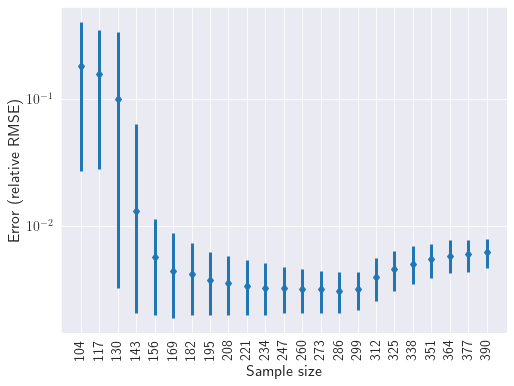

In [18]:
# Plot errors of cross-validation
filepath = '../output/paper0915/'
filename = 'error_cv_beta_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
plot_error_cv(error_stats, save_fig = True, save_path = f'{filepath}figure/',      fig_name = filename.split('.')[0], log_scale = True)

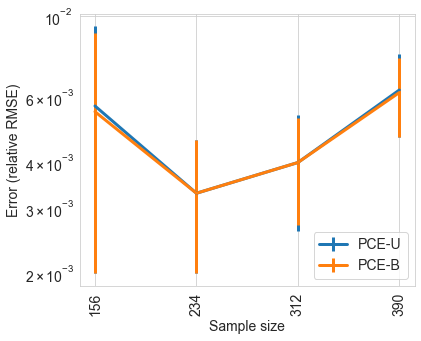

In [92]:
# Plot errors of cross-validation
from matplotlib import rcParams

filepath = '../output/paper0915/'
filename = 'error_cv_uniform_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
df_uniform = error_stats.iloc[[4, 10, 16, 22]]
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)

filename = 'error_cv_beta_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
cols = error_stats.columns
error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
df_beta = error_stats.iloc[[4, 10, 16, 22]]
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_beta], axis=1)
df_cols = df.columns
legend = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==0]
legend_low = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==1]
legend_up = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==2]

df = df.reset_index()
df.plot(x='index', y=legend, kind='line', figsize=(6,5),
                yerr=df.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df.shape[0]))

plt.xticks(ticks = np.arange(df.shape[0]), labels = [156, 234, 312, 390], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
plt.legend(['PCE-U', 'PCE-B'], loc='lower right', fontsize=14)
plt.ylabel('Error (relative RMSE)', fontsize = 14);
plt.xlabel('Sample size', fontsize = 14)
plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

Bar plot of sensitivity indices

In [50]:
# sensitivity plot
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig1_0811.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] File ../output/paper/sa_fig1_0811.csv does not exist: '../output/paper/sa_fig1_0811.csv'

In [37]:
str(r"${BEC^r}$")

'${BEC^r}$'

In [55]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.762550,0.099928,0.114356,0.759594,0.007180,0.006195,0.916264,0.007124,0.006454,new_BEC
3,RiparianVegPercent,0.085721,0.016571,0.017165,0.081979,0.003982,0.004238,0.054049,0.005774,0.006282,RVP
7,Beta,0.063841,0.011290,0.016928,0.062540,0.003493,0.003249,0.010991,0.001943,0.002280,Beta
4,USLE_HSDR_Fine,0.051351,0.008921,0.010443,0.052003,0.002840,0.003244,0.008928,0.001611,0.001836,USLEHF
8,LongTermAvDailyFlow,0.021809,0.004800,0.005501,0.022328,0.002341,0.002537,0.015533,0.002794,0.002902,LTADF
1,eventMeanConcentration,0.018327,0.003653,0.004227,0.018395,0.002125,0.002027,0.003321,0.000877,0.000982,EMC
2,HillslopeFineSDR,0.015537,0.003284,0.003620,0.015739,0.001800,0.002105,0.005837,0.001841,0.002282,new_HFSDR
6,RainThreshold,0.000891,0.000350,0.000502,0.000921,0.000345,0.000449,0.000175,0.000093,0.000261,RT
5,A3,0.000307,0.000213,0.000504,0.000292,0.000190,0.000387,0.000143,0.000116,0.000323,A3
9,Gully_Management_Practice_Factor,0.000303,0.000217,0.000443,0.000305,0.000212,0.000390,0.000176,0.000137,0.000406,new_GMPF


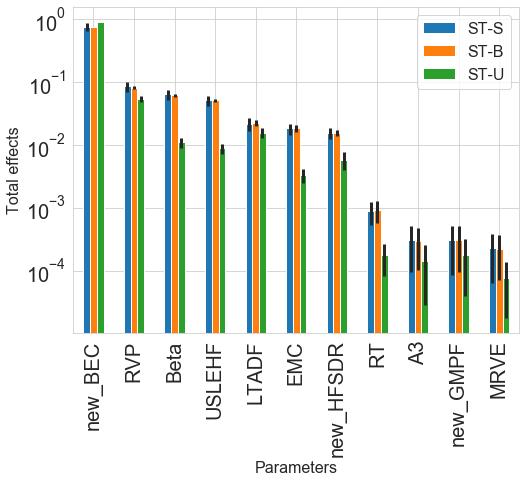

In [54]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig2_0812.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Beta', 'ST_Uniform']
legend_low = [lab+'_conf_lower' for lab in legend]
legend_up = [lab+'_conf_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_conf_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_conf_lower'] 
    df_plot.loc[:, f'{lab}_conf_upper'] = df_plot.loc[:, f'{lab}_conf_upper'] - df_plot.loc[:, lab]


sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
ax.set_xticklabels(df_plot.short_name.values, rotation=90);
ax.legend(['ST-S', 'ST-B', 'ST-U'])
# plt.savefig(f'{filepath}figure/sentivity_fig2-2log-line.png', format='png', dpi=300, bbox_inches='tight') 

In [8]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.762550,0.099928,0.114356,0.759594,0.007180,0.006195,0.916264,0.007124,0.006454,new_BEC
3,RiparianVegPercent,0.085721,0.016571,0.017165,0.081979,0.003982,0.004238,0.054049,0.005774,0.006282,RVP
7,Beta,0.063841,0.011290,0.016928,0.062540,0.003493,0.003249,0.010991,0.001943,0.002280,Beta
4,USLE_HSDR_Fine,0.051351,0.008921,0.010443,0.052003,0.002840,0.003244,0.008928,0.001611,0.001836,USLEHF
8,LongTermAvDailyFlow,0.021809,0.004800,0.005501,0.022328,0.002341,0.002537,0.015533,0.002794,0.002902,LTADF
1,eventMeanConcentration,0.018327,0.003653,0.004227,0.018395,0.002125,0.002027,0.003321,0.000877,0.000982,EMC
2,HillslopeFineSDR,0.015537,0.003284,0.003620,0.015739,0.001800,0.002105,0.005837,0.001841,0.002282,new_HFSDR
6,RainThreshold,0.000891,0.000350,0.000502,0.000921,0.000345,0.000449,0.000175,0.000093,0.000261,RT
5,A3,0.000307,0.000213,0.000504,0.000292,0.000190,0.000387,0.000143,0.000116,0.000323,A3
9,Gully_Management_Practice_Factor,0.000303,0.000217,0.000443,0.000305,0.000212,0.000390,0.000176,0.000137,0.000406,new_GMPF


Heat Map plot

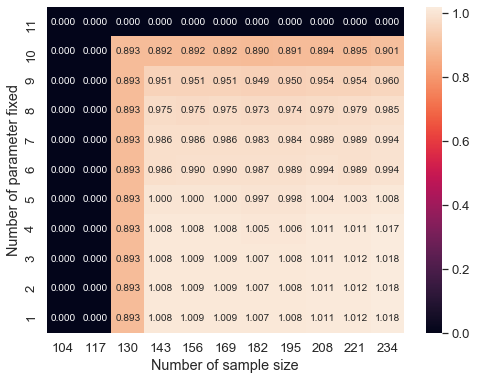

In [26]:
# heat map 
filepath = '../output/paper/error_measures/'
filename = 'conf_width_relative_95.csv'
df = pd.read_csv(f'{filepath}{filename}')
fpath_save = '../output/paper/figure/'
df.drop(columns={'Unnamed: 0'}, inplace=True)
sns.set(font_scale=1.2)
def plot_heatmap(df, save=False, save_name=None):    
    df.index = np.arange(df.shape[0], 0, -1)
    df = df.rename(columns={col: col.split('_')[1] for col in df.columns})
    fig = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(df.loc[:, df.columns[0:]], annot=True, fmt=".3f", annot_kws={"size": 10})
    ax.set_xlabel('Number of sample size')
    ax.set_ylabel('Number of parameter fixed')
    if save:
        plt.savefig(f'{fpath_save}{save_name}.png', format='png', dpi=300)
plot_heatmap(df, save=True, save_name=filename.split('.')[0])

Line plot for three error measures

In [4]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper/error_measures/0913/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']
# read statistics from the file y_uncond_stats.json
# with open(f'{filepath}y_uncond_stats.json', 'r') as fp: y_uncond_stat = json.load(fp)

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params + 1]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed
# df.loc[11, :] = [0, y_uncond_stat['cf_upper'], y_uncond_stat['cf_lower'], 
#                 y_uncond_stat['cv'], 1, 0, 1]

In [5]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 2 * df['cv']

In [6]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,ks,pvalue,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,11,2.725904e+07,2.725904e+07,0.000000,0.552028,5.516317e-117,2.725904e+07,2.725904e+07,2.725904e+07,2.725904e+07,...,-6.833128e-16,-4.099877e-16,-4.099877e-16,6.833128e-16,4.099877e-16,4.099877e-16,0.000000,-2.733251e-16,-2.733251e-16,0.000000
1,10,3.518637e+07,2.207408e+07,0.079487,0.064503,4.714835e-02,3.592200e+07,3.430593e+07,2.224104e+07,2.193351e+07,...,1.895963e-01,1.598298e-01,2.144666e-01,2.537099e-01,2.584624e-01,2.480652e-01,0.228994,2.339038e-01,2.231623e-01,0.158975
2,9,3.573947e+07,2.175469e+07,0.101798,0.053400,1.423947e-01,3.666487e+07,3.509000e+07,2.190986e+07,2.157929e+07,...,1.454270e-01,1.246120e-01,1.750856e-01,3.027762e-01,3.083976e-01,2.978031e-01,0.243238,2.493397e-01,2.378404e-01,0.203596
3,8,3.558681e+07,2.125534e+07,0.113480,0.039591,4.349088e-01,3.649347e+07,3.485594e+07,2.148357e+07,2.104931e+07,...,2.019425e-01,1.772572e-01,2.325649e-01,2.821021e-01,2.890609e-01,2.743936e-01,0.252128,2.593768e-01,2.440972e-01,0.226960
4,7,3.548077e+07,2.098877e+07,0.121500,0.031273,7.059919e-01,3.658595e+07,3.471427e+07,2.132244e+07,2.055570e+07,...,2.588885e-01,2.316922e-01,2.981011e-01,2.553004e-01,2.706660e-01,2.434615e-01,0.256634,2.719721e-01,2.448164e-01,0.243000
5,6,3.555634e+07,2.101042e+07,0.131602,0.028547,7.953990e-01,3.661224e+07,3.460743e+07,2.129805e+07,2.074547e+07,...,2.239901e-01,1.913249e-01,2.603384e-01,2.767382e-01,2.858588e-01,2.668368e-01,0.257146,2.665138e-01,2.469765e-01,0.263203
6,5,3.551241e+07,2.081574e+07,0.137795,0.024931,8.905986e-01,3.734331e+07,3.468573e+07,2.133467e+07,2.042397e+07,...,2.652876e-01,2.358336e-01,3.305217e-01,2.583467e-01,2.723052e-01,2.398573e-01,0.260912,2.748219e-01,2.424862e-01,0.275590
7,4,3.559140e+07,2.077299e+07,0.144379,0.013941,9.996565e-01,3.750697e+07,3.469750e+07,2.117341e+07,2.039829e+07,...,3.194930e-01,2.863529e-01,3.905094e-01,2.298753e-01,2.437669e-01,2.150304e-01,0.262904,2.761995e-01,2.486955e-01,0.288758
8,3,3.557027e+07,2.072878e+07,0.142170,0.013943,9.995934e-01,3.733298e+07,3.456124e+07,2.121716e+07,2.038475e+07,...,3.013852e-01,2.644684e-01,3.658761e-01,2.416103e-01,2.541971e-01,2.237424e-01,0.263619,2.758404e-01,2.462695e-01,0.284340
9,2,3.557027e+07,2.072878e+07,0.142170,0.013943,9.995934e-01,3.733298e+07,3.456124e+07,2.121716e+07,2.038475e+07,...,3.013852e-01,2.644684e-01,3.658761e-01,2.416103e-01,2.541971e-01,2.237424e-01,0.263619,2.758404e-01,2.462695e-01,0.284340


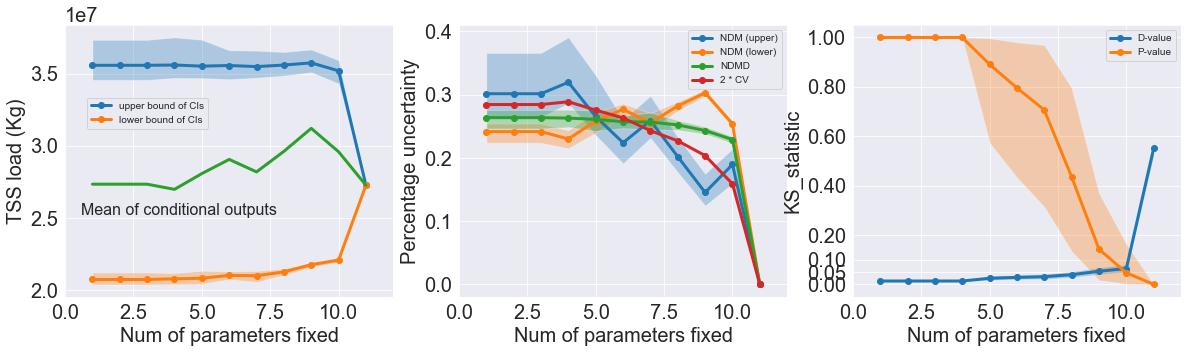

In [13]:
# Line plot
sns.set_style('darkgrid')
fs = 10
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(20, 5), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
# ax.axhline(c='grey',linestyle='--', y=y_uncond_stat['cf_upper']) 
ax.text(0.05, 0.30, 'Mean of conditional outputs', transform=ax.transAxes) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.45, 0.75))

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDM (upper)', 'NDM (lower)', 'NDMD', '2 * CV'], fontsize=fs)

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
fpath_save = '../output/paper/figure/'
# plt.savefig(f'{fpath_save}/measures_two_panel.png', format='png', dpi=300, bbox_inches='tight')

Line plot for showing robustness of error estimation

In [3]:
# Adaptive evaluation of error measure
filepath = '../output/paper/error_measures/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive',             'stats_uncond_adaptive']

In [4]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:-1]:
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[1]
df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation
cols = df.columns

In [5]:
df

,cf_lower_adaptive,cf_lower_lower_adaptive,cf_lower_upper_adaptive,cf_upper_adaptive,cf_upper_lower_adaptive,cf_upper_upper_adaptive,median
1000,2.207408e+07,2.193351e+07,2.224104e+07,3.518637e+07,3.430593e+07,3.592200e+07,2.863023e+07
1500,2.199612e+07,2.174389e+07,2.217457e+07,3.510876e+07,3.433855e+07,3.595990e+07,2.855244e+07
2000,2.198533e+07,2.185218e+07,2.211814e+07,3.486715e+07,3.441370e+07,3.532575e+07,2.842624e+07
2500,2.203432e+07,2.186901e+07,2.216856e+07,3.485498e+07,3.454905e+07,3.524810e+07,2.844465e+07
3000,2.196812e+07,2.181989e+07,2.214111e+07,3.491663e+07,3.465268e+07,3.535883e+07,2.844237e+07
3500,2.199756e+07,2.188835e+07,2.211567e+07,3.455879e+07,3.430500e+07,3.488578e+07,2.827818e+07
4000,2.201296e+07,2.186744e+07,2.214184e+07,3.514839e+07,3.488201e+07,3.547215e+07,2.858068e+07
4500,2.204381e+07,2.193657e+07,2.213337e+07,3.482064e+07,3.460303e+07,3.512531e+07,2.843222e+07
5000,2.208322e+07,2.197188e+07,2.219098e+07,3.480525e+07,3.442523e+07,3.508025e+07,2.844423e+07
5500,2.206165e+07,2.199310e+07,2.214018e+07,3.490465e+07,3.462693e+07,3.527401e+07,2.848315e+07


In [6]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

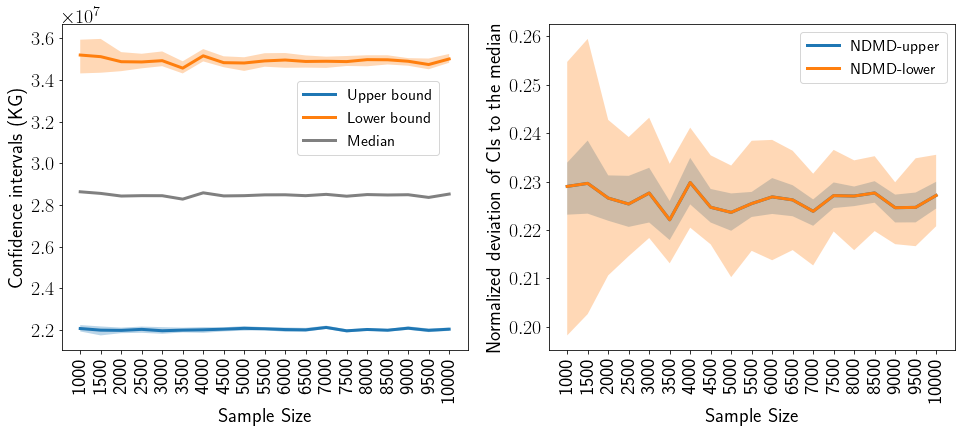

In [8]:

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2)
ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[0])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend(['Upper bound', 'Lower bound', 'Median'], bbox_to_anchor=[0.95, 0.85])

ax1 = df_ratio[cols[[0, 3]]].plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(range(len(df_ratio.index)), df_ratio.index, rotation=90)
ax1.fill_between(df.index, df_ratio[cols[1]], df_ratio[cols[2]], alpha=0.3)
ax1.fill_between(df.index, df_ratio[cols[4]], df_ratio[cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('Normalized deviation of CIs to the median');
ax1.legend(['NDMD-upper', 'NDMD-lower']);
plt.savefig('../output/paper/figure/'+'conf_adaptive_two_panels.png', format='png', dpi=300, layout='tight')